## HW 3
### Due Apr. 15th by end of day.
### Name your notebook by firstname.lastname.hw3.ipynb and email it to zhang@csc.lsu.edu

In this HW, we take a look at text processing using RNN based on LSTM. Given a review (hundred to thousand words long) about a movie, we want to classify the review as positive or negative (sentiment analysis). A model is given in this notebook that runs RNN, consisting of a single layer of LSTM cells, on the word sequence of the rewiews. Each review is transformed into a vector, which is the average of the LSTM vectors over the sequence. A softmax layer is then used to classify the reviews based on the LSTM vector representation. 

Your goal is to train the model and gain some idea on the computation challenge when training "deep" model for a large number of iterations.  

In [28]:
# for python 2
from __future__ import print_function

In [29]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import time

import numpy
import theano
import theano.tensor as T

from lstm import load_data, prepare_data, batches_idx, lstm_layer, rmsprop
import pandas as pd

### Model meta parameters

 - n_hidden: # of neurons in the LSTM layer
 - n_words: # of words in the dictionary. We use most frequent words. All other words are treated as unknown.
 - n_sample: max size (# of reviews) of the train dataset and the test dataset. (We may not be able to reach the max because if we want only reviews up to 50 words, there may be less than max such reviews in the whole data collection.)  
 - maxlen: max length in number of words for a review to be considered. Review longer than this will be ignored. This is also the # of recurrent steps.


In [32]:
df = pd.read_csv('../input/err0_len20/format1')
df = df.iloc[np.random.permutation(len(df))]
print(df.shape)

ntrain=500
ntest=100

d = df[0:ntrain]
train = (d.ix[:,:-1].values.tolist(), d.ix[:,-1].values.tolist())

d = df[ntrain:ntrain+ntest]
test = (d.ix[:,:-1].values.tolist(), d.ix[:,-1].values.tolist())

(100000, 42)


In [33]:
print('num of pos in train:', numpy.sum(train[1]), 'out of', len(train[1]))
print('num of pos in test:', numpy.sum(test[1]), 'out of', len(test[1]))

num of pos in train: 243 out of 500
num of pos in test: 45 out of 100


In [34]:
n_hidden=41
n_words=7

In [35]:
def build_model(n_hidden, n_words):

    x = T.matrix('x', dtype='int64')
    mask = T.matrix('mask', dtype='float64')
    y = T.vector('y', dtype='int64')

    # embedding params
    randn = numpy.random.rand(n_words, n_hidden)
    Wemb = theano.shared(0.01 * randn)
    
    #lstm layer
    lstm = lstm_layer(n_hidden)
    
    # classifier params
    CU = theano.shared(0.01 * numpy.random.randn(n_hidden, 2))
    Cb = theano.shared(numpy.zeros((2,)))
    params = lstm.params + [Wemb, CU, Cb]
    
    
    n_timesteps = x.shape[0]
    n_samples = x.shape[1]

    emb = Wemb[x.flatten()].reshape([n_timesteps, n_samples, n_hidden])
    proj = lstm.calc_lstm(emb, mask)
    proj = (proj * mask[:, :, None]).sum(axis=0)
    proj = proj / mask.sum(axis=0)[:, None]

    pred = T.nnet.softmax(T.dot(proj, CU) + Cb)

    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    cost = -T.log(pred[T.arange(n_samples), y] + off).mean()

    return x, mask, y, params, cost, f_pred

In [36]:
(x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
grads = T.grad(cost, params)    

lr = T.scalar(name='lr')
f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

lrate=0.1
updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
f_sgd = theano.function([x, mask, y], cost, updates=updates)

In [37]:
#nepoch = 200
nepoch = 10000
cc = numpy.zeros((nepoch,))

sampling_iter = 50
nepoch2 = int(nepoch / sampling_iter)
cc2 = numpy.zeros((nepoch2,))
cc2_idx = numpy.zeros((nepoch2,))



t0 = time.time()
for i in range(nepoch):
    cost = 0
    for train_index in batches_idx(len(train[0]), 200):
        y = [train[1][t] for t in train_index]
        x = [train[0][t] for t in train_index]
        x, mask, y = prepare_data(x, y)
        
        cost += f_grad_shared(x, mask, y)
        f_update(lrate)
        #cost += f_sgd(x, mask, y)
    
    cc[i] = cost
    if i % 10 == 0:
        print(i, cost, end = ' ')
        #print(i)

    if i % sampling_iter == 0:
        tx2, tmask2, ty2 = prepare_data(test[0], test[1])
        py2 = f_pred(tx2, tmask2)
        err_rate = 1.0*numpy.sum(numpy.abs(ty2 - py2))/len(test[0])
        i2 = int(i / sampling_iter)
        cc2[i2] = err_rate
        cc2_idx[i2] = i
        #print(i, err_rate)


print('')
print('run time:', (time.time()-t0)/60.0, "minutes")  #training time in min.

0 2.07943030062 10 2.07782354538 20 2.07725389298 30 2.07710327173 40 2.07706127696 50 2.07704946775 60 2.07704617272 70 2.07704519781 80 2.07704479892 90 2.07704450917 100 2.07704421758 110 2.07704390612 120 2.07704357746 130 2.07704323669 140 2.07704288758 150 2.07704253242 160 2.07704217249 170 2.07704180839 180 2.07704144037 190 2.07704106848 200 2.07704069266 210 2.07704031275 220 2.0770399286 230 2.07703954 240 2.07703914675 250 2.07703874863 260 2.0770383454 270 2.07703793686 280 2.07703752274 290 2.07703710282 300 2.07703667685 310 2.07703624458 320 2.07703580575 330 2.07703536009 340 2.07703490735 350 2.07703444725 360 2.07703397951 370 2.07703350384 380 2.07703301995 390 2.07703252755 400 2.07703202632 410 2.07703151596 420 2.07703099615 430 2.07703046656 440 2.07702992685 450 2.07702937668 460 2.0770288157 470 2.07702824355 480 2.07702765985 490 2.07702706423 500 2.0770264563 510 2.07702583566 520 2.07702520189 530 2.07702455459 540 2.07702389331 550 2.07702321762 560 2.0770

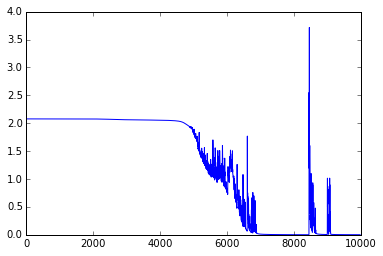

In [38]:
plot(cc[20:])

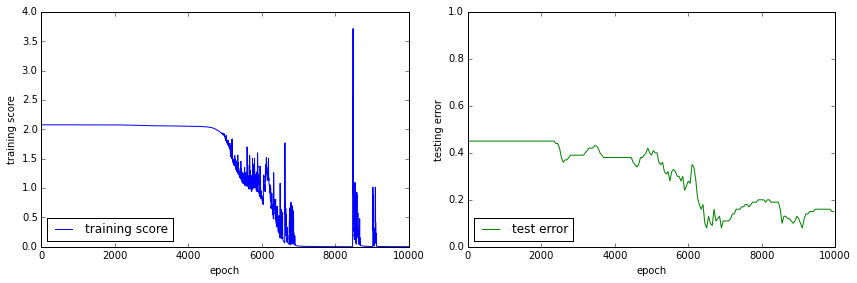

In [39]:
nx = 2
ny = 1
fig = plt.figure(figsize = [6 * nx, 4 * ny]) # inch

ax0 = fig.add_subplot(ny, nx, 1)
plot(cc)
plt.legend(['training score'], loc='lower left')
ax0.set_xlim(0)
ax0.set_ylim(0)
ax0.set_ylabel('training score')
ax0.set_xlabel('epoch')

ax1 = fig.add_subplot(ny, nx, 2)
plot(cc2_idx, cc2, color='g')
plt.legend(['test error'], loc='lower left')
ax1.set_xlim(0)
ax1.set_ylim(0, 1)
ax1.set_ylabel('testing error')
ax1.set_xlabel('epoch')

fig.tight_layout()





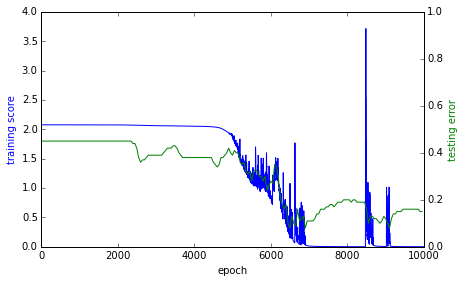

In [40]:
nx = 2
ny = 1
fig = plt.figure(figsize = [6 * nx, 4 * ny]) # inch

ax0 = fig.add_subplot(ny, nx, 1)
plot(cc, color='b')
#plt.legend(['training score'], loc='lower left')
ax0.set_xlim(0)
ax0.set_ylim(0)
ax0.set_ylabel('training score', color='b')
ax0.set_xlabel('epoch')

ax1 = ax0.twinx()
plot(cc2_idx, cc2, color='g')
#plt.legend(['test error'], loc='lower left')
ax1.set_xlim(0)
ax1.set_ylim(0, 1)
ax1.set_ylabel('testing error', color='g')
ax1.set_xlabel('epoch')

fig.tight_layout()

In [ ]:
np.min(cc)

In [ ]:
def get_err(data):
    tx, tmask, ty = prepare_data(data[0], data[1])
    py = f_pred(tx, tmask)
    err_rate = 1.0*numpy.sum(numpy.abs(ty - py))/len(data[0])
    return err_rate


print(get_err(train))
print(get_err(test))

In [26]:
def benchmark1(n_hidden = 10, n_words = 500, n_sample = 1000, maxlen = 50):
    ########################
    train, test, translate = load_data('./', n_words, n_sample, maxlen)

    
    ########################    
    (x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
    grads = T.grad(cost, params)    

    lr = T.scalar(name='lr')
    f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

    lrate=0.1
    updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
    f_sgd = theano.function([x, mask, y], cost, updates=updates)

    
    ########################
    nepoch = 500
    cc = numpy.zeros((nepoch,))
    t0 = time.time()
    for i in range(nepoch):
        cost = 0
        for train_index in batches_idx(len(train[0]), 100):
            y = [train[1][t] for t in train_index]
            x = [train[0][t]for t in train_index]
            x, mask, y = prepare_data(x, y)

            cost += f_grad_shared(x, mask, y)
            f_update(lrate)
            #cost += f_sgd(x, mask, y)

        cc[i] = cost
        #print('iteration:', i, 'cost=', cost)
        #if i % 10 == 0:
            #print(i, end = ' ')
    print('')
    t1 = time.time()
    ts = (t1 - t0) / 60.0 # training time in min
    return ts

In [27]:
ts = benchmark1()
print(ts)


0.312066249053


## Task 1
Investigate test error rate with respect to training iterations. 

  - Plot error rate for test data v.s. number of iterations.  
  
Train the model until "cost" gets close to 0 (smaller than 0.01). You don't need to get error rate every iteration. Rather, every 250 or 500 iterations, call f_pred to make prediction on the test data and calculated error rate (an example is given above for prediction and error rate calculation).

### Make plot on this notebook and submit the notebook with the plot. I'd like to see the plot besides your code.
### DONE

In [14]:
nepoch = 10000
cc = numpy.zeros((nepoch,))

sampling_iter = 100 # get error rate every 100 iterations
nepoch2 = int(nepoch / sampling_iter)
cc2 = numpy.zeros((nepoch2,))
cc2_idx = numpy.zeros((nepoch2,))


t0 = time.time()
for i in range(nepoch):
    cost = 0
    for train_index in batches_idx(len(train[0]), 100):
        y = [train[1][t] for t in train_index]
        x = [train[0][t] for t in train_index]
        x, mask, y = prepare_data(x, y)
        
        cost += f_grad_shared(x, mask, y)
        f_update(lrate)
        #cost += f_sgd(x, mask, y)
    
    cc[i] = cost
    if i % 100 == 0:
        print(i, end = ' ')
        #print(i)

    if i % sampling_iter == 0:
        tx2, tmask2, ty2 = prepare_data(test[0], test[1])
        py2 = f_pred(tx2, tmask2)
        err_rate = 1.0*numpy.sum(numpy.abs(ty2 - py2))/len(test[0])
        i2 = int(i / sampling_iter)
        cc2[i2] = err_rate
        cc2_idx[i2] = i
        #print(i, err_rate)

print('')
print('run time:', (time.time()-t0)/60.0, "minutes")  #training time in min.

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 
run time: 16.2011261662 minutes


test cost of the last 20 iterations:
[ 0.00020194  0.00020191  0.00020189  0.00020186  0.00020184  0.00020181
  0.00020179  0.00020176  0.00020174  0.00020171  0.00020169  0.00020167
  0.00020164  0.00020162  0.00020159  0.00020157  0.00020154  0.00020152
  0.00020149  0.00020147]
test cost (y) / iterations (x):


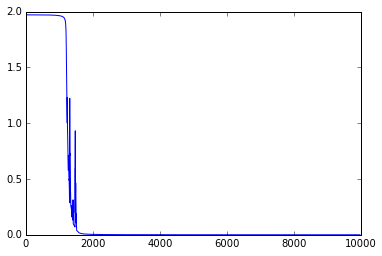

In [24]:
print("training cost of the last 20 iterations:")
print(cc[-20:])

print("training cost (y) / iterations (x):")
plot(cc[20:])

testing error rate (y) / iterations (x):


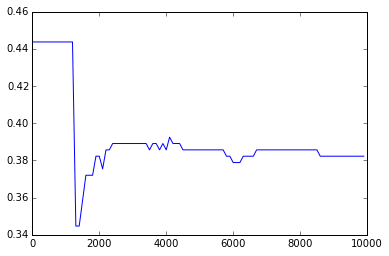

In [28]:
print("testing error rate (y) / iterations (x):")
plot(cc2_idx, cc2)

In [93]:
nepoch = 2500
cc = numpy.zeros((nepoch,))

sampling_iter = 10 # get error rate every 10 iterations
nepoch2 = int(nepoch / sampling_iter)
cc2 = numpy.zeros((nepoch2,))
cc2_idx = numpy.zeros((nepoch2,))


t0 = time.time()
for i in range(nepoch):
    cost = 0
    for train_index in batches_idx(len(train[0]), 100):
        y = [train[1][t] for t in train_index]
        x = [train[0][t] for t in train_index]
        x, mask, y = prepare_data(x, y)
        
        cost += f_grad_shared(x, mask, y)
        f_update(lrate)
        #cost += f_sgd(x, mask, y)
    
    cc[i] = cost
    if i % 100 == 0:
        print(i, end = ' ')
        #print(i)

    if i % sampling_iter == 0:
        tx2, tmask2, ty2 = prepare_data(test[0], test[1])
        py2 = f_pred(tx2, tmask2)
        err_rate = 1.0*numpy.sum(numpy.abs(ty2 - py2))/len(test[0])
        i2 = int(i / sampling_iter)
        cc2[i2] = err_rate
        cc2_idx[i2] = i
        #print(i, err_rate)

print('')
print('run time:', (time.time()-t0)/60.0, "minutes")  #training time in min.

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 
run time: 4.10253929694 minutes


training cost of the last 20 iterations:
[ 0.00285276  0.00284899  0.00284523  0.00284148  0.00283774  0.00283401
  0.00283029  0.00282658  0.00282288  0.00281918  0.0028155   0.00281183
  0.00280816  0.00280451  0.00280086  0.00279722  0.0027936   0.00278998
  0.00278637  0.00278277]
training cost (y) / iterations (x):


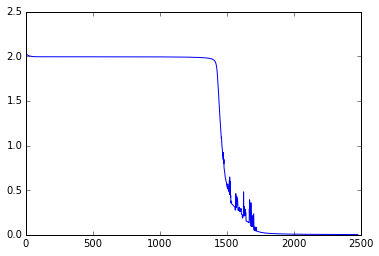

In [94]:
print("training cost of the last 20 iterations:")
print(cc[-20:])

print("training cost (y) / iterations (x):")
plot(cc[20:])

testing error rate (y) / iterations (x):


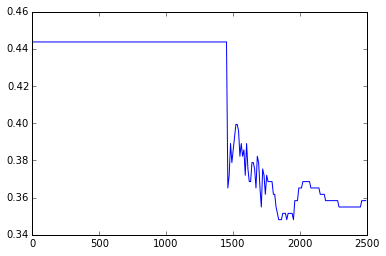

In [95]:
print("testing error rate (y) / iterations (x):")
plot(cc2_idx, cc2)

## Task 2
Investigate training time with respect to the following parameters:
  - n_hidden (# of neurons in the LSTM layer)
  - maxlen (max length in number of words for a review), i.e., # of recurrent steps

Fix the number of training iterations (i.e., 200), vary (increase the values of) the parameters and measure the training time. (Don't make small changes of values, e.g., from 10 to 11. You should make significant change of the values, e.g., from 10 to 20 to 50 to 100 etc.) Try several values and make the following plots: 
  - training time v.s. n_hidden
  - training time v.s. maxlen
  
### Make plot on this notebook and submit the notebook with the plot. I'd like to see the plot besides your code.
### DONE



In [58]:
n_hidden = []
n_hidden_log2 = []
training_time = []

for i in range(1, 9):
    para = 2 ** i
    #ts = 1
    ts = benchmark1(n_hidden=para, n_words = 500, n_sample = 1000, maxlen = 50)
    print(para, end = ' ')
    n_hidden.append(para)
    n_hidden_log2.append(i)
    training_time.append(ts)
print('')



2 
4 
8 
16 
32 
64 
128 
256 


[0.07621726592381796, 0.11921043395996093, 0.23265220324198405, 0.5806679169336955, 1.6257498184839885, 5.488786816596985, 19.93946446577708, 74.40915466547013]
[2, 4, 8, 16, 32, 64, 128, 256]


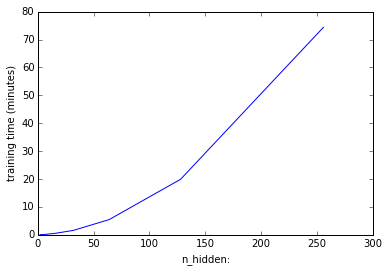

In [75]:
print(training_time)
print(n_hidden)
plt.ylabel('training time (minutes)')
plt.xlabel('n_hidden:')
plot(n_hidden, training_time)

In [62]:
maxlen2 = []
maxlen2_log2 = []
training2_time = []

for i in range(1, 8):
    para = 2 ** i
    #ts = 1
    ts = benchmark1(n_hidden=10, n_words = 500, n_sample = 1000, maxlen = para)
    print(para, end = ' ')
    maxlen2.append(para)
    maxlen2_log2.append(i)
    training2_time.append(ts)
print('')


2 
4 
8 
16 
32 
64 
128 


[8.749961853027344e-06, 1.5000502268473307e-05, 1.5083948771158854e-05, 0.006113465627034505, 0.028030081590016683, 1.125632401307424, 2.930569863319397]
[2, 4, 8, 16, 32, 64, 128]


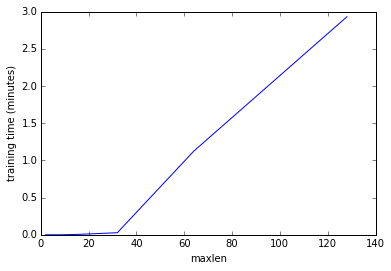

In [79]:
print(training2_time)
print(maxlen2)
plt.ylabel('training time (minutes)')
plt.xlabel('maxlen')
plot(maxlen2, training2_time)